# Gerenal API quickstart
* https://docs.pymc.io/en/v3/pymc-examples/examples/pymc3_howto/api_quickstart.html

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

warnings.simplefilter(action="ignore", category=FutureWarning)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC3 v3.11.2
Running on ArviZ v0.11.2


## 1. Model creation
* PyMC3에서는 Model Class를 사용한다. 여기에 모든 랜덤변수의 참조가 들어가고, model 관련 logp계산과 gradients도 계산한다. with와 같이 사용한다.

In [3]:
with pm.Model() as model:
    # Model definition
    pass

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

In [4]:
model.basic_RVs # see above for reference Random Variables

[mu ~ Normal, obs ~ Normal]

In [5]:
model.free_RVs

[mu ~ Normal]

In [6]:
model.observed_RVs

[obs ~ Normal]

In [7]:
model.logp({"mu": 0})

array(-151.9898758)

In [8]:
%timeit model.logp({mu: 0.1})
logp = model.logp
%timeit logp({mu: 0.1})

52.7 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.2 µs ± 375 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


* logp는 static하지 않다. 그래서 cache하는데 오래 걸리는데, 만약 logp=model.logp로 static하게 만들어 버리면 빨라진다.

## 2. Probability Distributions
* 모든 확률적 프로그램은 관찰된 랜덤변수, 관찰하지 않은 랜덤변수를 구성한다. 관찰된 RVs는 likelihood 분포로 정의되고, 관찰하지 않은 RVs는 선험분포로 정의된다. PyMC3에서는 main module에서 확률분포를 사용할 수 있다. 

In [9]:
help(pm.Normal) # example of probability distributions and documentation

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Normal(name, *args, **kwargs)
 |  
 |  Univariate normal log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      mus = [0., 0., 0., -2.]
 |      sigmas = [0.4, 1., 2., 0.4]
 |      for mu, sigma in zip(mus, sigmas):
 |          pdf = st.norm.pdf(x, mu, sigma)
 |          plt.plot(x, pdf, labe

In [15]:
print(dir(pm.distributions))
print(dir(pm.distributions.continuous))
print(dir(pm.distributions.discrete))
print(dir(pm.distributions.timeseries))
print(dir(pm.distributions.mixture))

['AR', 'AR1', 'AsymmetricLaplace', 'BART', 'Bernoulli', 'Beta', 'BetaBinomial', 'Binomial', 'Bound', 'Categorical', 'Cauchy', 'ChiSquared', 'Constant', 'ConstantDist', 'Continuous', 'DensityDist', 'Dirichlet', 'DirichletMultinomial', 'Discrete', 'DiscreteUniform', 'DiscreteWeibull', 'Distribution', 'ExGaussian', 'Exponential', 'Flat', 'GARCH11', 'Gamma', 'GaussianRandomWalk', 'Geometric', 'Gumbel', 'HalfCauchy', 'HalfFlat', 'HalfNormal', 'HalfStudentT', 'HyperGeometric', 'Interpolated', 'InverseGamma', 'KroneckerNormal', 'Kumaraswamy', 'LKJCholeskyCov', 'LKJCorr', 'Laplace', 'Logistic', 'LogitNormal', 'Lognormal', 'MatrixNormal', 'Mixture', 'MixtureSameFamily', 'Moyal', 'Multinomial', 'MvGaussianRandomWalk', 'MvNormal', 'MvStudentT', 'MvStudentTRandomWalk', 'NegativeBinomial', 'NoDistribution', 'Normal', 'NormalMixture', 'OrderedLogistic', 'OrderedProbit', 'Pareto', 'Poisson', 'Rice', 'Simulator', 'SkewNormal', 'StudentT', 'TensorType', 'Triangular', 'TruncatedNormal', 'Uniform', 'VonM

* 위 output에서 볼수 있듯, PyMC3의 probability distribution 구조는 다음과 같다.
* pymc3.distributions - continuous - discrete - timeseries - mixture

### Unobserved Random Variables
* 모든 관찰하지 않은 RV는 arg로 name(str)과 관련 parameter를 받는다. 

In [17]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)

x.logp({"x": 0})

array(-0.91893853)

### Observed Random Variables
* 관찰되는 RV는 위의 관찰하지 않은 RV와 arg를 비슷하게 받지만, 추가적으로 observed라는 arg를 받아야 한다.
* observed에는 list, numpy.ndarray, theano, pandas dataframe를 줄 수 있다. 

In [18]:
with pm.Model():
    obs = pm.Normal("x", mu=0, sigma=1, observed=np.random.randn(100))

### Deterministic transforms
* PyMC3는 RV를 가지고 algebra를 할수있도록 지원한다.

In [19]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x ** 2
    sined = pm.math.sin(x)

* 자연스런게 대수 계산이 되긴 하지만, 저장이 자동적으로 되는 것은 아니다. 이것 변환된(대수 계산한) 변수들을 계속 쓰고 싶다면, pm.Deterministic을 사용해야 한다. 

In [20]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    plus_2 = pm.Deterministic("x plus 2", x + 2)

### Automatic transforms of bounded RVs
* PyMC3는 bounded RV는 unbounded로 자동적으로 변환해준다. 

In [21]:
with pm.Model() as model:
    x = pm.Uniform("x", lower = 0, upper = 1)

model.free_RVs

[x_interval__ ~ TransformedDistribution]

* "x_interval__"은 x가 (-inf, +inf) 사이의 parameter 값을 받을 수 있도록 자동적 변환되었음을 말한다. upper, lower bound에 대해서 LogOdds 변환이 적용되었다. 이렇게 변환된 공간에서 sample이 더 수월하다. PyMC3는 물론 non-transformed, bounded parameter도 추적하며, 이것은 deterministics로 되어있다.

In [22]:
model.deterministics

[x ~ Uniform]

* PyMC3가 결과를 보여줄 때는 변환된 parameter는 숨김 처리한다. include_transformed=True라고 하면 볼 수 있다. 
* 반대로 transform자체를 끌 수도 있다. 

In [25]:
with pm.Model() as model:
    x = pm.Uniform("x", lower = 0, upper = 1, transform=None)

model.free_RVs

[x ~ Uniform]

* 또는 transform형태를 지정해줄수도 있다. 

In [26]:
import pymc3.distributions.transforms as tr

with pm.Model() as model:
    # default log transformation
    x1 = pm.Gamma("x1", alpha=1, beta=1)
    # log exp transform
    x2 = pm.Gamma("x2", alpha=1, beta=1, transform=tr.log_exp_m1)

print("The default transformation of x1 is: " + x1.transformation.name)
print("The user specified transformation of x2 is: " + x2.transformation.name)

The default transformation of x1 is: log
The user specified transformation of x2 is: log_exp_m1


### Transformed distributions and changes of variables
* PyMC3는 한 분포에서 다른 분포로 변환하는 것을 명시적으로 제공하지 않는다. 하지만, 변환 분포를 만들 수 있다. kwarg를 줘서. 다음 Normal distribution을 LogNormal로 변환하는 다음 예시를 보자.

$$ log(y) \sim Normal(\mu, \sigma) $$


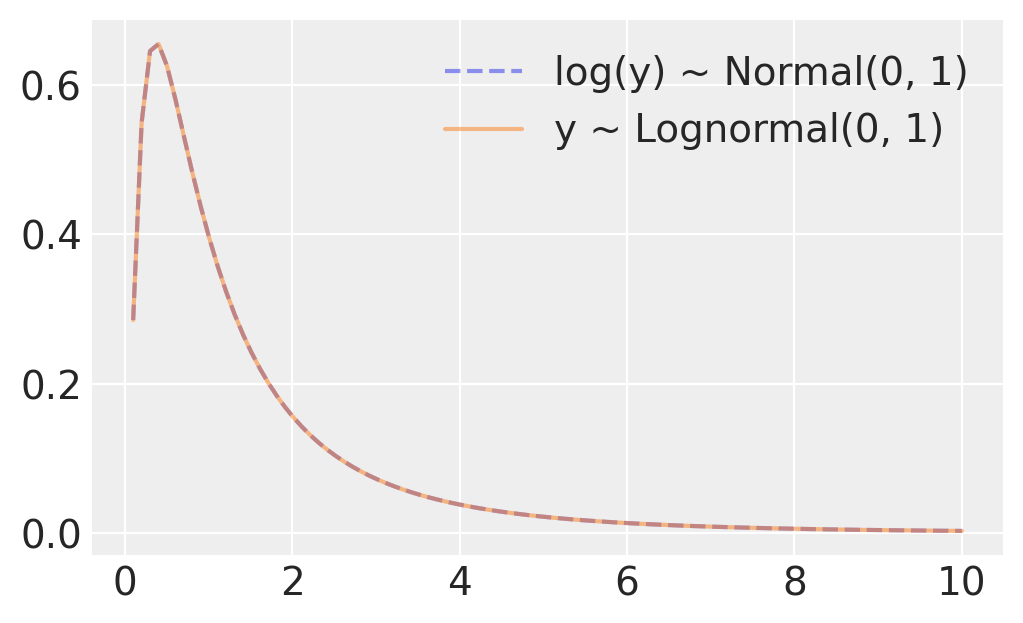

In [27]:
class Exp(tr.ElemwiseTransform):
    name = "exp"

    def backward(self, x):
        return tt.log(x)

    def forward(self, x):
        return tt.exp(x)

    def jacobian_det(self, x):
        return -tt.log(x)

with pm.Model() as model:
    x1 = pm.Normal("x1", 0.0, 1.0, transform=Exp())
    x2 = pm.Lognormal("x2", 0.0, 1.0)

lognorm1 = model.named_vars["x1_exp__"]
lognorm2 = model.named_vars["x2"]

_, ax = plt.subplots(1,1, figsize=(5,3))
x = np.linspace(0.0, 10.0, 100)

ax.plot(
    x,
    np.exp(lognorm1.distribution.logp(x).eval()),
    "--",
    alpha = 0.5,
    label = "log(y) ~ Normal(0, 1)"
)
ax.plot(
    x,
    np.exp(lognorm2.distribution.logp(x).eval()),
    alpha = 0.5,
    label = "y ~ Lognormal(0, 1)"
)
plt.legend()

In [ ]:
# TODO restart from 23st cells in the above link